# DJ - HS Causal Inference

This notebook loads stock market data from the Dow Jones (DJ) Industrial Average and Hang Seng (HS) stock market indices and looks at the sample path causal measure between the two.

1. **[Imports](#imports)**
2. **[Load Data](#load-data)**
3. **[Preprocessing](#preprocess)**
4. **[Computing Causal Measure](#causal)**
5. **[Computing Partial Causal Measure](#causalp)**

------
## Imports <a class="anchor" id="imports"></a>

In [70]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib.patches import Patch
import pandas as pd
from scipy.io import savemat, loadmat
%matplotlib inline

font = {'family' : 'serif',
        'size'   : 16}
matplotlib.rc('font', **font)

import sys
sys.path
sys.path.append('../python/')
from ctw import CTW

# Avoid the "if self._edgecolors == str('face')" FutureWarning
import warnings
warnings.filterwarnings('ignore')

save_figs = False
fig_dir = '../figs/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


------
## Load Data <a class="anchor" id="load-data"></a>

First we'll load the data. Because there are different holidays in China and the US, we first align all the data by date and then interpolate missing dates. Note that this does not interpolate over weekends (or other dates where both stock markets are closed), but just select dates where only one is open.

In [170]:
# load the data
dji = pd.read_csv('./DJI.csv')
hsi = pd.read_csv('./HSI.csv')
# convert adjusted closing price to numeric values
dji['Adj Close'] = pd.to_numeric(dji['Adj Close'], errors='coerce')
hsi['Adj Close'] = pd.to_numeric(hsi['Adj Close'], errors='coerce')
# convert date field to date type
dji['Date'] = pd.to_datetime(dji['Date'])
hsi['Date'] = pd.to_datetime(hsi['Date'])
# set the date as the dataframe's indexing field
dji.set_index(['Date'],inplace=True)
hsi.set_index(['Date'],inplace=True)
# align dates
(dji,hsi) = dji.align(hsi)
# interpolate missing dates (respective holidays)
dji = dji.interpolate()
hsi = hsi.interpolate()

Next we'll simply plot the adjusted closing price over time.

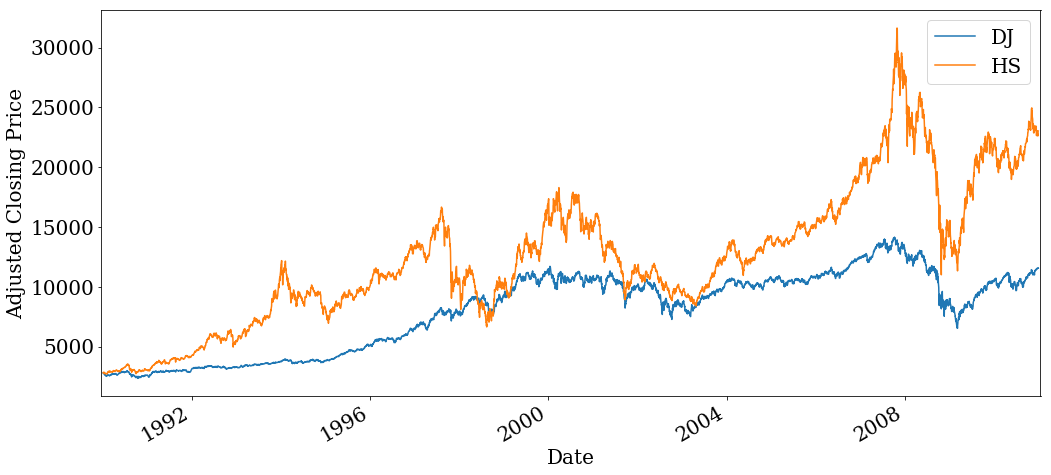

In [72]:
font = {'family' : 'serif',
        'size'   : 20}
matplotlib.rc('font', **font)

plt.figure(figsize=(15,7))
dji['Adj Close'].plot(label='DJ',)
hsi['Adj Close'].plot(label='HS')
plt.ylabel('Adjusted Closing Price')
plt.legend()
xlim = plt.xlim()
plt.xlim([xlim[0]+365,xlim[1]-365])
plt.tight_layout()
if save_figs:
    plt.savefig(fig_dir+'dji_hsi_t.png',dpi=200);

------
## Preprocessing <a class="anchor" id="preprocess"></a>

In order to utilize context tree weighting (CTW) prediction, we first apply two preprocessing steps from [this paper on the universal estimators of directed information](https://arxiv.org/abs/1201.2334). Namely, we look at the quantized daily percent difference in adjusted closing price, which is set to 0 if the stock goes down by more than 0.8%, 2 if it goes up by more the 0.8%, and 1 if it does not change by more than 0.8%.

In [73]:
# for each adjusted closing cost, find the percentage change from the previous day
ddji = [0]
for i in range(1,len(dji['Adj Close'])):
    ddji.append((dji['Adj Close'][i]-dji['Adj Close'][i-1])/dji['Adj Close'][i-1])
dji['Adj Close Diff'] = ddji

dhsi = [0]
for i in range(1,len(hsi['Adj Close'])):
    dhsi.append((hsi['Adj Close'][i]-hsi['Adj Close'][i-1])/hsi['Adj Close'][i-1])
hsi['Adj Close Diff'] = dhsi

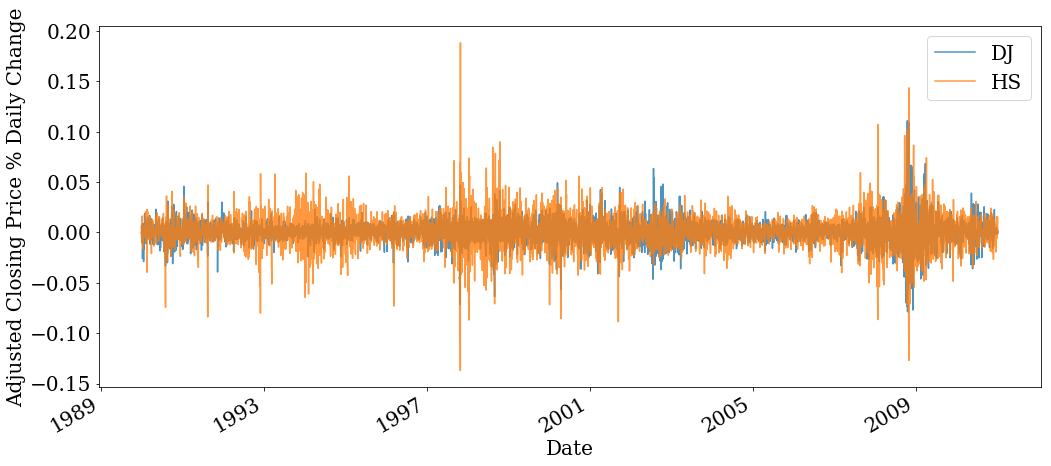

In [74]:
plt.figure(figsize=(15,7))
dji['Adj Close Diff'].plot(label='DJ',alpha=0.8)
hsi['Adj Close Diff'].plot(label='HS',alpha=0.8)
plt.ylabel('Adjusted Closing Price % Daily Change')
plt.legend()
plt.tight_layout()

In [75]:
# quantize each to be 0, 1, or 2 based on a 0.8% threshold
thresh = 0.8/100
ddji = [0]
for i in range(1,len(dji['Adj Close Diff'])):
    diff = dji['Adj Close Diff'][i]
    if diff < -thresh: ddji.append(0)
    elif diff > thresh: ddji.append(2)
    else: ddji.append(1)
dji['Adj Close Diff Quant'] = ddji

dhsi = [0]
for i in range(1,len(hsi['Adj Close Diff'])):
    diff = hsi['Adj Close Diff'][i]
    if diff < -thresh: dhsi.append(0)
    elif diff > thresh: dhsi.append(2)
    else: dhsi.append(1)
hsi['Adj Close Diff Quant'] = dhsi

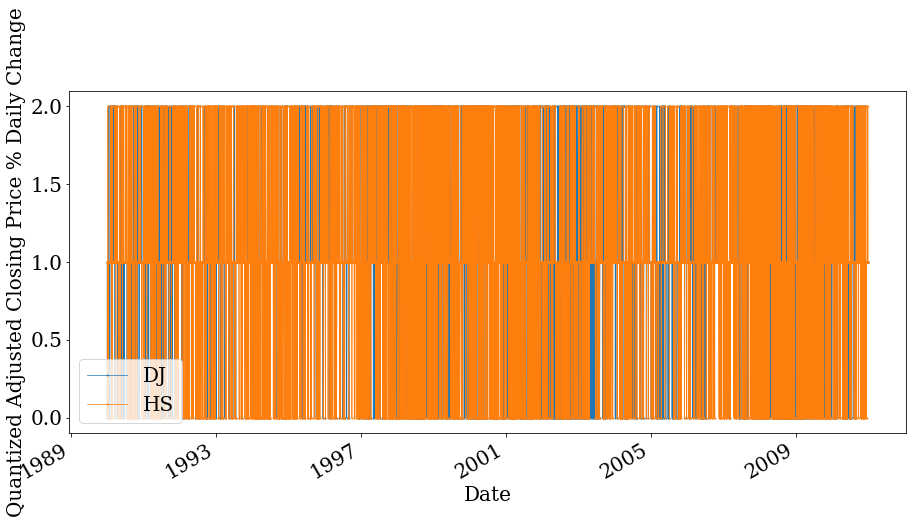

In [76]:
plt.figure(figsize=(15,7))
dji['Adj Close Diff Quant'].plot(linewidth=0.7,marker='o',label='DJ',alpha=1,markersize=0.9)
hsi['Adj Close Diff Quant'].plot(linewidth=0.7,marker='o',label='HS',alpha=1,markersize=0.9)
plt.ylabel('Quantized Adjusted Closing Price % Daily Change')
plt.legend(frameon=True);

------
## Computing Causal Measure <a class="anchor" id="causal"></a>

Once we have our two ternary sequences we are ready to compute the causal measure. The necessary machinery we need are CTW predictors (imported from [here](https://github.com/gabeschamberg/context-tree-weighting)) and a KL divergence function (below). One slightly nuanced step of note: in computing the influence of HS on DJ, we need to shift the HS time series ahead by one sample. This is because, on a given day, the Shanghai Stock Exchange (SSE) closes before the New York Stock Exchange (NYSE) opens. Thus, in order to be consistent with our convention of ignoring "instantaneous causation", we need to view "today's" HS price as "yesterday's" HS price.

In [136]:
def kl(d1,d2):
    kl = 0
    for i in range(len(d1)):
        kl += d1[i]*np.log2(d1[i]/d2[i])
    return kl

In [158]:
# Depth of tree
D = 1

# create two context trees for predicting based on complete history
ctwdc = CTW(depth=D,symbols=3,sidesymbols=3)
ctwhc = CTW(depth=D,symbols=3,sidesymbols=3)

# create two context trees for predicting based on restricted history
ctwdr = CTW(depth=D,symbols=3)
ctwhr = CTW(depth=D,symbols=3)

# create copies to avoid undesired overwrites
dj = np.copy(dji['Adj Close Diff Quant'])
hs = np.copy(hsi['Adj Close Diff Quant'])

# create the shifted data for evaluating HS->DJ
hs_ = np.copy(hs[1:])
dj_ = np.copy(dj[:-1])

# compute four sets of probabilities for DJ/HS complete/restricted
fdcs = ctwdc.predict_sequence(dj_,sideseq=hs_)
fdrs = ctwdr.predict_sequence(dj_)
fhcs = ctwhc.predict_sequence(hs,sideseq=dj)
fhrs = ctwhr.predict_sequence(hs)

# for each direction, append the kl divergences at each time
ch2d = []
cd2h = []
for i in range(fdrs.shape[1]):
    ch2d.append(kl(fdcs[:,i],fdrs[:,i]))
    cd2h.append(kl(fhcs[:,i],fhrs[:,i]))

Next we'll plot a sample of how the causal influences evolve over time. As we can see, DJ has a greater influence on HS than vice versa. Even so, most of the days there is very little influence in either direction. 

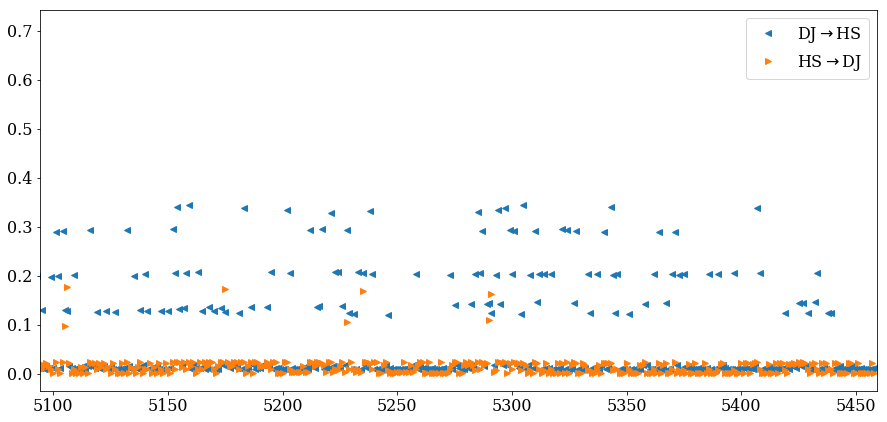

In [159]:
plt.figure(figsize=(15,7))
plt.plot(cd2h,linewidth=0,marker='<',label=r'DJ$\rightarrow$HS')
plt.plot(ch2d,linewidth=0,marker='>',label=r'HS$\rightarrow$DJ')
plt.legend();
plt.xlim([len(cd2h)-365,len(cd2h)]);

An easier way to visualize this is by looking at the causal measure for specific previous day changes. Thus, we'll collect the causal measure over days with shared previous day changes and represent them as a box-plot to demonstrate a decent level of consistency over the final year.

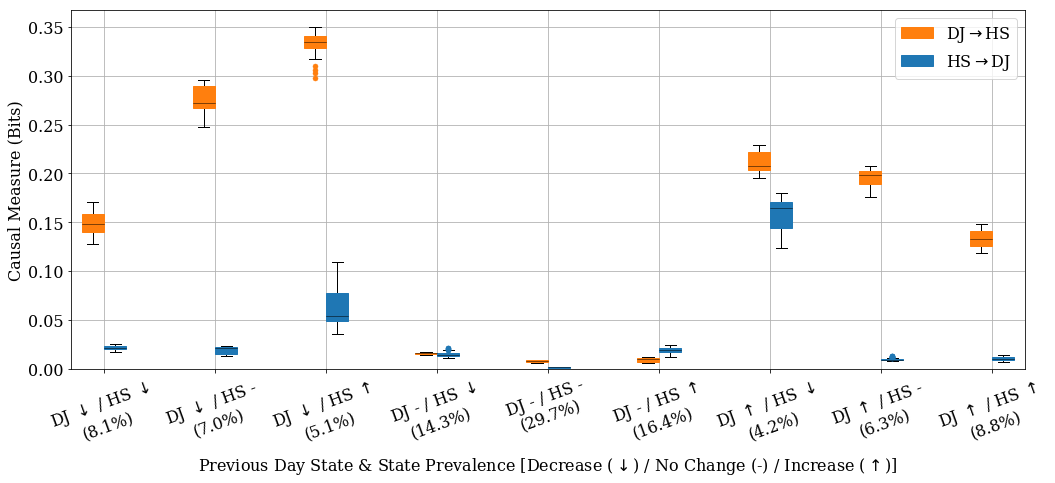

In [160]:
font = {'family' : 'serif',
        'size'   : 16}
matplotlib.rc('font', **font)

# create a dictionary that will contain the causal measures for each context
results = {0:{0:{'d2h':[],'h2d':[]},
              1:{'d2h':[],'h2d':[]},
              2:{'d2h':[],'h2d':[]}},
           1:{0:{'d2h':[],'h2d':[]},
              1:{'d2h':[],'h2d':[]},
              2:{'d2h':[],'h2d':[]}},
           2:{0:{'d2h':[],'h2d':[]},
              1:{'d2h':[],'h2d':[]},
              2:{'d2h':[],'h2d':[]}}}

n = len(cd2h)
# only consider the final year in the box plot
start = n-3*365
for i in range(start,n):
    # We first predict the Dth sample (+D), but that causal measure is associated with the previous context (-1)
    ddji = dj[i+D-1]
    dhsi = hs[i+D-1]  
    d2h = cd2h[i]
    results[ddji][dhsi]['d2h'].append(d2h)
    # use the shifted data for the HS->DJ measure
    ddji = dj_[i+D-1]
    dhsi = hs_[i+D-1]   
    h2d = ch2d[i]
    results[ddji][dhsi]['h2d'].append(h2d)

###### Plotting stuff
c = [r'$\downarrow$','-',r'$\uparrow$']
inds = range(9)
positions = []
width = 0.2
for i in inds:
    positions.append(i)
    positions.append(i+width)
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
labels = []
data = []
for i in [0,1,2]:
    for j in [0,1,2]:
        ind = 3*i + j
        d2h = results[i][j]['d2h']
        h2d = results[i][j]['h2d']
        per = 100*len(d2h)/(n-start)
        data.append(d2h)
        data.append(h2d)
        labels.append('DJ %s / HS %s\n(%2.1f%%)'%(c[i],c[j],per))

medianprops = dict(color='black',linewidth=0.5)
flierprops = dict(marker='o', markerfacecolor='grey',markeredgecolor='black',markersize=5,linestyle='none')
bplot = ax.boxplot(data,positions=positions,widths=width,patch_artist=True,medianprops=medianprops,flierprops=flierprops)
import seaborn as sns
colors = [sns.xkcd_rgb["soft green"],sns.xkcd_rgb["soft blue"]]
colors = ['#ff7f0e','#1f77b4']
for i,(patch,flier) in enumerate(zip(bplot['boxes'],bplot['fliers'])):
    patch.set_facecolor(colors[np.mod(i,2)])
    patch.set_edgecolor(colors[np.mod(i,2)])
    flier.set_markerfacecolor(colors[np.mod(i,2)])
    flier.set_markeredgecolor(colors[np.mod(i,2)])
    flier.set_markeredgewidth(0.5)
ax.set_ylabel('Causal Measure (Bits)')
ax.set_xlabel(r'Previous Day State & State Prevalence [Decrease ($\downarrow$) / No Change (-) / Increase ($\uparrow$)]')
ax.set_xticks(np.asarray(inds)+width/2)
ax.set_xticklabels(labels,rotation=20)
ax.set_xlim([inds[0]-width,inds[-1]+2*width])

legend_elements = [Patch(facecolor=colors[0], edgecolor=colors[0],label=r'DJ$\rightarrow$HS'),
                   Patch(facecolor=colors[1], edgecolor=colors[1],label=r'HS$\rightarrow$DJ')]
ax.legend(handles=legend_elements,frameon=True)
ax.grid('on')
ylim = ax.get_ylim()
ax.set_ylim([0,ylim[1]])
plt.tight_layout()
if save_figs:
    plt.savefig(fig_dir+'dji_hsi_c.png',dpi=200);

------
## Computing Partial Causal Measure <a class="anchor" id="causalp"></a>


In [162]:
# Depth of tree
D = 1
# Staleness used for computing partial causal measure (see below)
staleness = 1

# create two context trees for predicting based on complete history
ctwdc = CTW(depth=D,symbols=3,sidesymbols=3)
ctwhc = CTW(depth=D,symbols=3,sidesymbols=3)

# create two context trees for predicting with stale history
ctwdr = CTW(depth=D+staleness,symbols=3,sidesymbols=3,staleness=staleness)
ctwhr = CTW(depth=D+staleness,symbols=3,sidesymbols=3,staleness=staleness)

# create copies to avoid undesired overwrite
dj = np.copy(dji['Adj Close Diff Quant'])
hs = np.copy(hsi['Adj Close Diff Quant'])

# shift data for computing HS->DJ
hs_ = np.copy(hs[1:])
dj_ = np.copy(dj[:-1])

# predict sequences (now restricted predictors have a sidesequence)
fdcs = ctwdc.predict_sequence(dj_,sideseq=hs_)
fhcs = ctwhc.predict_sequence(hs,sideseq=dj)
fdrs = ctwdr.predict_sequence(dj_,sideseq=hs_)
fhrs = ctwhr.predict_sequence(hs,sideseq=dj)

# restricted predictors have larger depth => fewer predictions => need to offset which are compared
ch2d = []
cd2h = []
for i in range(fdrs.shape[1]):
    ch2d.append(kl(fdcs[:,i+staleness],fdrs[:,i]))
    cd2h.append(kl(fhcs[:,i+staleness],fhrs[:,i]))

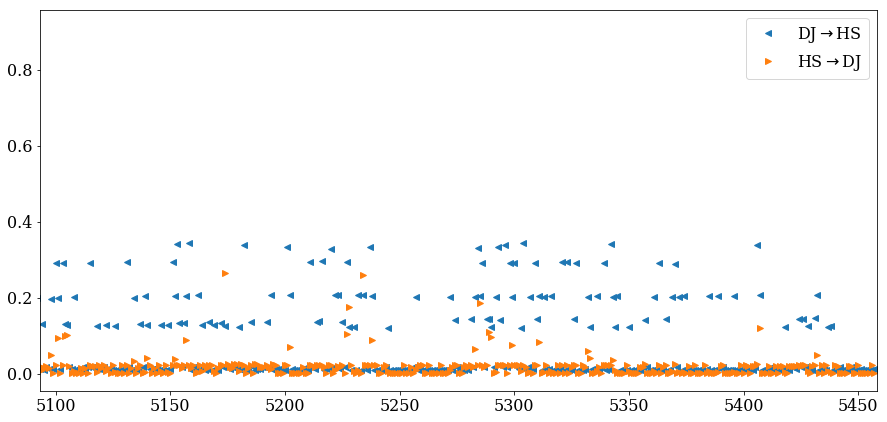

In [163]:
plt.figure(figsize=(15,7))
plt.plot(cd2h,linewidth=0,marker='<',label=r'DJ$\rightarrow$HS')
plt.plot(ch2d,linewidth=0,marker='>',label=r'HS$\rightarrow$DJ')
plt.legend();
plt.xlim([len(cd2h)-365,len(cd2h)]);

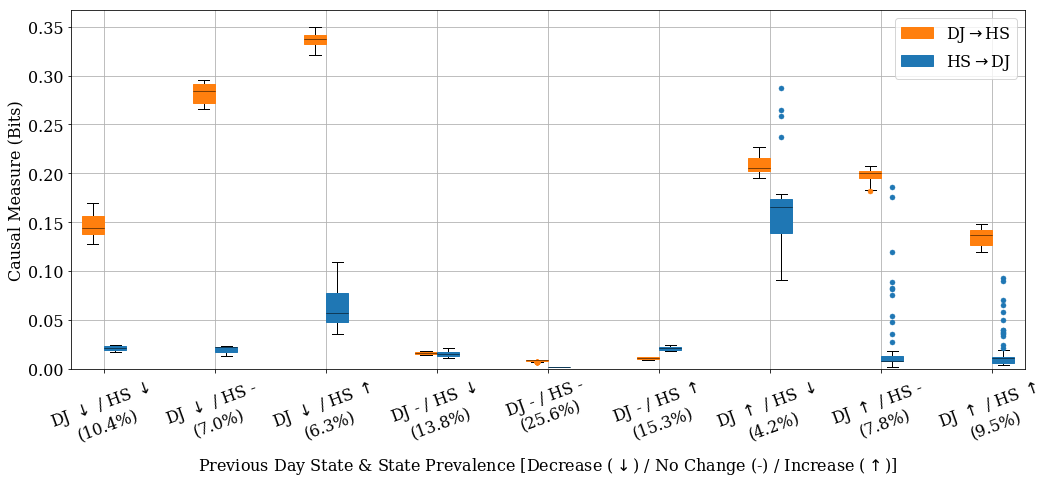

In [169]:
font = {'family' : 'serif',
        'size'   : 16}
matplotlib.rc('font', **font)

# create a dictionary that will contain the causal measures for each context
results = {0:{0:{'d2h':[],'h2d':[]},
              1:{'d2h':[],'h2d':[]},
              2:{'d2h':[],'h2d':[]}},
           1:{0:{'d2h':[],'h2d':[]},
              1:{'d2h':[],'h2d':[]},
              2:{'d2h':[],'h2d':[]}},
           2:{0:{'d2h':[],'h2d':[]},
              1:{'d2h':[],'h2d':[]},
              2:{'d2h':[],'h2d':[]}}}

n = len(cd2h)
# only consider the final year in the box plot
start = n-2*365
for i in range(start,n):
    # for each sample the ith causal measure corresponds with the i+1th context because now using depth 2 tree
    ddji = dj[i+D+staleness-1]
    dhsi = hs[i+D+staleness-1]  
    d2h = cd2h[i]
    results[ddji][dhsi]['d2h'].append(d2h)
    # use the shifted data for the i+1th context for HS->DJ measure
    ddji = dj_[i+D+staleness-1]
    dhsi = hs_[i+D+staleness-1]   
    h2d = ch2d[i]
    results[ddji][dhsi]['h2d'].append(h2d)

###### Plotting stuff
c = [r'$\downarrow$','-',r'$\uparrow$']
inds = range(9)
positions = []
width = 0.2
for i in inds:
    positions.append(i)
    positions.append(i+width)
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
labels = []
data = []
for i in [0,1,2]:
    for j in [0,1,2]:
        ind = 3*i + j
        d2h = results[i][j]['d2h']
        h2d = results[i][j]['h2d']
        per = 100*len(d2h)/(n-start)
        data.append(d2h)
        data.append(h2d)
        labels.append('DJ %s / HS %s\n(%2.1f%%)'%(c[i],c[j],per))

medianprops = dict(color='black',linewidth=0.5)
flierprops = dict(marker='o', markerfacecolor='grey',markeredgecolor='black',markersize=5,linestyle='none')
bplot = ax.boxplot(data,positions=positions,widths=width,patch_artist=True,medianprops=medianprops,flierprops=flierprops)
import seaborn as sns
colors = [sns.xkcd_rgb["soft green"],sns.xkcd_rgb["soft blue"]]
colors = ['#ff7f0e','#1f77b4']
for i,(patch,flier) in enumerate(zip(bplot['boxes'],bplot['fliers'])):
    patch.set_facecolor(colors[np.mod(i,2)])
    patch.set_edgecolor(colors[np.mod(i,2)])
    flier.set_markerfacecolor(colors[np.mod(i,2)])
    flier.set_markeredgecolor(colors[np.mod(i,2)])
    flier.set_markeredgewidth(0.5)
ax.set_ylabel('Causal Measure (Bits)')
ax.set_xlabel(r'Previous Day State & State Prevalence [Decrease ($\downarrow$) / No Change (-) / Increase ($\uparrow$)]')
ax.set_xticks(np.asarray(inds)+width/2)
ax.set_xticklabels(labels,rotation=20)
ax.set_xlim([inds[0]-width,inds[-1]+2*width])

legend_elements = [Patch(facecolor=colors[0], edgecolor=colors[0],label=r'DJ$\rightarrow$HS'),
                   Patch(facecolor=colors[1], edgecolor=colors[1],label=r'HS$\rightarrow$DJ')]
ax.legend(handles=legend_elements,frameon=True)
ax.grid('on')
ylim = ax.get_ylim()
ax.set_ylim([0,ylim[1]])
plt.tight_layout()
if save_figs:
    plt.savefig(fig_dir+'dji_hsi_pc.png',dpi=200);